# Exploring Overfitting in NLP

In [34]:
import csv
import random
import pickle
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress
from google.colab import files

## Getting data

In [2]:
# Upload files to Google Colab
files.upload()

Saving glove.6B.100d.zip to glove.6B.100d.zip
Saving training_cleaned.zip to training_cleaned.zip


In [3]:
# Unzip archives
def unzip(zipped):
  zip_ref = zipfile.ZipFile(zipped, 'r')
  zip_ref.extractall()
  zip_ref.close()

unzip('training_cleaned.zip')
unzip('glove.6B.100d.zip')

## Defining global variables

In [4]:
SENTIMENT_CSV = "training_cleaned.csv" # dataset file
GLOVE_FILE = 'glove.6B.100d.txt' # file with pre-defined 100-dimensional embeddings
EMBEDDING_DIM = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9

## Exploring the dataset

In [5]:
with open(SENTIMENT_CSV, 'r') as csvfile:
  print('First data record looks like this:\n', csvfile.readline())
  print('Second data record looks like this:\n', csvfile.readline())

First data record looks like this:
 "0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

Second data record looks like this:
 "0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"



## Parsing data

In [6]:
def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file
    Args:
        filename (string): path to the CSV file
    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences, labels = [], []
    with open(filename, 'r') as csvfile:
      csvreader = csv.reader(csvfile, delimiter=',')
      for row in csvreader:
        sentences.append(row[5])
        labels.append(0 if row[0]=='0' else 1)
    return sentences, labels

In [7]:
# Test the function
sentences, labels = parse_data_from_file(SENTIMENT_CSV)

print(f"dataset contains {len(sentences)} examples\n")

print(f"Text of second example should look like this:\n{sentences[1]}\n")
print(f"Text of fourth example should look like this:\n{sentences[3]}")

print(f"\nLabels of last 5 examples should look like this:\n{labels[-5:]}")

dataset contains 1600000 examples

Text of second example should look like this:
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

Text of fourth example should look like this:
my whole body feels itchy and like its on fire 

Labels of last 5 examples should look like this:
[1, 1, 1, 1, 1]


In [8]:
# Cut the dataset to the MAX_EXAMPLES

# Bundle sentences and labels together
sentences_and_labels = list(zip(sentences, labels))

# Sample to the MAX_EXAMPLES
random.seed(42)
sentences_and_labels = random.sample(sentences_and_labels, MAX_EXAMPLES)

# Unpack back to separate lists
sentences, labels = zip(*sentences_and_labels)

print(f"There are {len(sentences)} sentences and {len(labels)} labels after random sampling\n")

There are 160000 sentences and 160000 labels after random sampling



## Training - Validation Split

In [9]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets
    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set
    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """
    train_size = int(len(sentences)*training_split)
    train_sentences = sentences[:train_size]
    validation_sentences = sentences[train_size:]
    train_labels = labels[:train_size]
    validation_labels = labels[train_size:]

    return train_sentences, validation_sentences, train_labels, validation_labels

In [10]:
# Test the function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 144000 sentences for training.

There are 144000 labels for training.

There are 16000 sentences for validation.

There are 16000 labels for validation.


## Tokenization - Sequences, truncating and padding

In [11]:
def fit_tokenizer(train_sentences, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        oov_token (string) - symbol for the out-of-vocabulary token
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(train_sentences)

    return tokenizer

In [12]:
# Test the function
tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'i' should be {word_index['i']}")

Vocabulary contains 128293 words

<OOV> token included in vocabulary

index of word 'i' should be 2


In [13]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        truncating (string): type of truncating to use
        maxlen (int): maximum length of the token sequence
    Returns:
        pad_trunc_sequences (array of int): tokenized sentences padded to the same length
    """
    sequences = tokenizer.texts_to_sequences(sentences)
    pad_trunc_sequences = pad_sequences(sequences, padding=padding, truncating=truncating, maxlen=maxlen)

    return pad_trunc_sequences

In [14]:
# Test the function
train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (144000, 16)

Padded and truncated validation sequences have shape: (16000, 16)


In [15]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

## Using pre-defined Embeddings

In [16]:
# Check the Clove embeddings file data
with open(GLOVE_FILE, 'r') as f:
  print('Data record looks like this:\n', f.readline())

Data record looks like this:
 the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062



In [17]:
# Retreive Glove embedding from file
GLOVE_EMBEDDINGS = {}
with open(GLOVE_FILE, 'r') as f:
  for row in f:
    data = row.split()
    word = data[0]
    embedding = np.asarray(data[1:], dtype='f')
    GLOVE_EMBEDDINGS[word] = embedding

In [19]:
# Check Glove embeddings

test_word = 'dog'
test_vector = GLOVE_EMBEDDINGS[test_word]
print(f"GloVe has embeddings for {len(GLOVE_EMBEDDINGS)} words")
print(f"Each word vector has shape: {test_vector.shape}")
print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

GloVe has embeddings for 400000 words
Each word vector has shape: (100,)
Vector representation of word dog looks like this:

[ 0.30817    0.30938    0.52803   -0.92543   -0.73671    0.63475
  0.44197    0.10262   -0.09142   -0.56607   -0.5327     0.2013
  0.7704    -0.13983    0.13727    1.1128     0.89301   -0.17869
 -0.0019722  0.57289    0.59479    0.50428   -0.28991   -1.3491
  0.42756    1.2748    -1.1613    -0.41084    0.042804   0.54866
  0.18897    0.3759     0.58035    0.66975    0.81156    0.93864
 -0.51005   -0.070079   0.82819   -0.35346    0.21086   -0.24412
 -0.16554   -0.78358   -0.48482    0.38968   -0.86356   -0.016391
  0.31984   -0.49246   -0.069363   0.018869  -0.098286   1.3126
 -0.12116   -1.2399    -0.091429   0.35294    0.64645    0.089642
  0.70294    1.1244     0.38639    0.52084    0.98787    0.79952
 -0.34625    0.14095    0.80167    0.20987   -0.86007   -0.15308
  0.074523   0.40816    0.019208   0.51587   -0.34428   -0.24525
 -0.77984    0.27425    0.22418

## Represent the words in vocabulary using the GloVe embeddings

In [22]:
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
  embedding = GLOVE_EMBEDDINGS.get(word)
  if embedding is not None:
    EMBEDDINGS_MATRIX[i] = embedding

## Build and train a model

In [36]:
def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    """
    Creates a binary sentiment classifier model
        Args:
        vocab_size (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
        embeddings_matrix (array): predefined weights of the embeddings
    Returns:
        model (tf.keras Model): the sentiment classifier model
    """
    model = tf.keras.Sequential([
        Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(6, activation='relu'),
        Dense(1)
    ])
    model.compile(
        'adam',
        loss = tf.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

In [37]:
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)
history = model.fit(train_pad_trunc_seq, train_labels, epochs=20, validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/20
4500/4500 [==============================] - 27s 6ms/step - loss: 0.5899 - accuracy: 0.6510 - val_loss: 0.5371 - val_accuracy: 0.7196
Epoch 2/20
4500/4500 [==============================] - 29s 6ms/step - loss: 0.5459 - accuracy: 0.6988 - val_loss: 0.5242 - val_accuracy: 0.7196
Epoch 3/20
4500/4500 [==============================] - 26s 6ms/step - loss: 0.5331 - accuracy: 0.7086 - val_loss: 0.5166 - val_accuracy: 0.7359
Epoch 4/20
4500/4500 [==============================] - 26s 6ms/step - loss: 0.5228 - accuracy: 0.7160 - val_loss: 0.5123 - val_accuracy: 0.7333
Epoch 5/20
4500/4500 [==============================] - 26s 6ms/step - loss: 0.5143 - accuracy: 0.7230 - val_loss: 0.5169 - val_accuracy: 0.7386
Epoch 6/20
4500/4500 [==============================] - 27s 6ms/step - loss: 0.5076 - accuracy: 0.7300 - val_loss: 0.5071 - val_accuracy: 0.7235
Epoch 7/20
4500/4500 [==============================] - 26s 6ms/step - loss: 0.5019 - accuracy: 0.7341 - val_loss: 0.5113 - val_ac

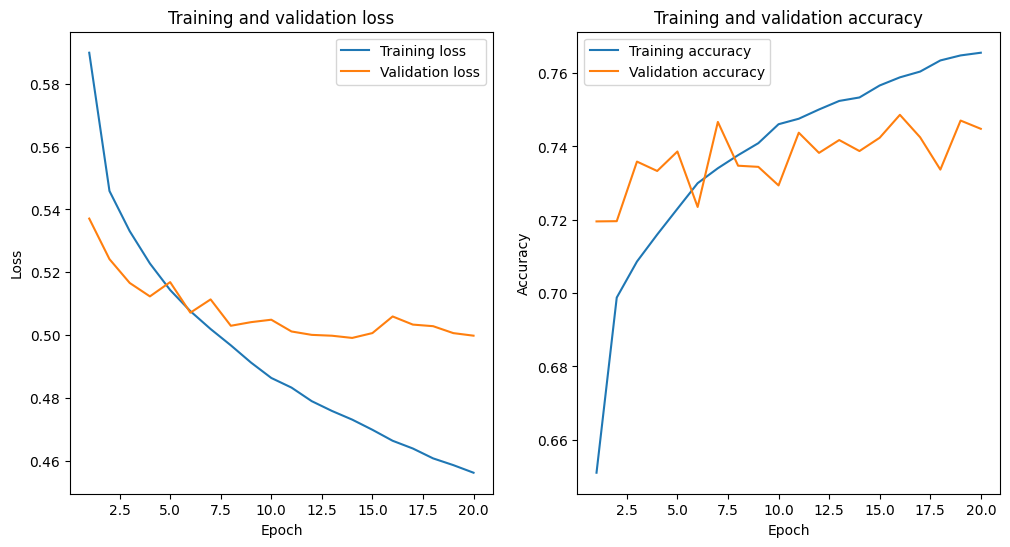

In [38]:
# Plot model training history
from math import ceil

def plot_params(params: list[str]=[], validation=True):
  num_params = len(params)
  num_rows = ceil(num_params/2)
  epochs = [epoch for epoch in range(1, len(history.history[params[0]])+1)]
  plt.figure(figsize=(12, 6*num_rows))
  for i in range(0, num_params):
    s = plt.subplot(num_rows, 2, i+1)
    par = params[i]
    s.plot(epochs, history.history[par], label=f'Training {par}')
    # s.set_xticks(epochs)
    s.set_xlabel('Epoch')
    s.set_ylabel(par.capitalize())
    if validation:
      s.plot(epochs, history.history[f'val_{par}'], label=f'Validation {par}')
      s.set_title(f'Training and validation {par}')
    else:
      s.set_title(f'Training {par}')
    s.legend()

plot_params(['loss', 'accuracy'])

In [39]:
# Test the slope of val_loss curve
slope, *_ = linregress([*range(20)], history.history['val_loss'])
print(f"The slope of the validation loss curve is {slope:.5f}")

The slope of the validation loss curve is -0.00130
